In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [2]:
# data
var = 0.2
def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

In [3]:
data_size = 20000
x=gen_x()
y=gen_y(x)
p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
print(mi)
mi_numerical = mutual_info_regression(x.reshape(-1, 1), y.ravel())[0]
print(mi_numerical)


0.6597659294763042
0.6599751776903059


/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


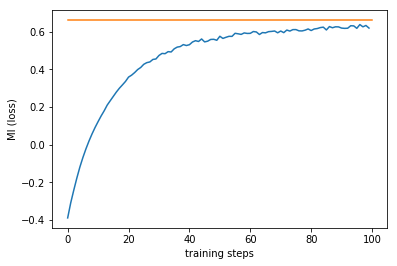

In [4]:
H=20
n_epochs = 200
data_size = 20000

def Net(x_in, y_in):
    
    # shuffle the data and append to the end (so that they are processed by the same net)
    y_shuffle = tf.random_shuffle(y_in)
    x_conc = tf.concat([x_in, x_in], axis=0)
    y_conc = tf.concat([y_in, y_shuffle], axis=0)
    
    # propagate the forward pass
    layerx = layers.linear(x_conc, H)
    layery = layers.linear(y_conc, H)
    layer2 = tf.nn.relu(layerx + layery)
    output = layers.linear(layer2, 1)
    
    # split in T_xy and T_x_y predictions
    #N_samples = tf.cast(tf.shape(x_in)[0], tf.int32)
    N_samples = tf.shape(x_in)[0]
    T_xy = output[:N_samples]
    T_x_y = output[N_samples:]
    
    return T_xy, T_x_y

def NegLoss(x_in, y_in):
    
    T_xy, T_x_y = Net(x_in, y_in)
    neg_loss = -(tf.reduce_mean(T_xy, axis=0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y))))
    
    return neg_loss

# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, 1], name='x_in')
y_in = tf.placeholder(tf.float32, [None, 1], name='y_in')

# make the loss and optimisation graphs
neg_loss = NegLoss(x_in, y_in)
opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(neg_loss)

# run the session and training
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []
for epoch in range(n_epochs):
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    
    feed_dict = {x_in:x_sample, y_in:y_sample}
    _, neg_l = sess.run([opt, neg_loss], feed_dict=feed_dict)
    
    MIs.append(-neg_l)

fig, ax = plt.subplots()
ax.plot(range(len(MIs)), MIs)
ax.plot([0, len(MIs)], [mi,mi], label='analytic form')
ax.set_xlabel('training steps')
ax.set_ylabel('MI (loss)')
fig.show()
